# LYFT 2019 Bike Ridership in San Francisco
### by Richard Zheng

## Investigation Overview

> I am investigating a dataset, from Ford GoBike, that contains data about LYFT bike usage to see which factors affect ride durations.

In [1]:
# import all packages and set plots to be embedded inline
import pandas as pd
import seaborn as sb
import numpy as np
import zipfile
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Extract downloaded zip files and combine them into a dataframe
files = ['201901-fordgobike-tripdata.csv.zip','201902-fordgobike-tripdata.csv.zip',
         '201903-fordgobike-tripdata.csv.zip','201904-fordgobike-tripdata.csv.zip',
        '201905-baywheels-tripdata.csv.zip','201906-baywheels-tripdata.csv.zip',
        '201907-baywheels-tripdata.csv.zip','201908-baywheels-tripdata.csv.zip',
        '201909-baywheels-tripdata.csv.zip','201910-baywheels-tripdata.csv.zip',
        '201911-baywheels-tripdata.csv.zip','201912-baywheels-tripdata.csv.zip']
df = pd.DataFrame()
for file in files:
    with zipfile.ZipFile(file, 'r') as myzip:
        myzip.extractall()
    month = pd.read_csv(file[:-4],low_memory = False)
    df = pd.concat([df,month]) 

In [3]:
df.reset_index().head()

,index,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,bike_share_for_all_trip,rental_access_method
0,0,80825,2019-01-31 17:57:44.6130,2019-02-01 16:24:49.8640,229.0,Foothill Blvd at 42nd Ave,37.775745,-122.213037,196.0,Grand Ave at Perkins St,37.808894,-122.256460,4861,Subscriber,No,NaN
1,1,65900,2019-01-31 20:58:33.8860,2019-02-01 15:16:54.1730,4.0,Cyril Magnin St at Ellis St,37.785881,-122.408915,134.0,Valencia St at 24th St,37.752428,-122.420628,5506,Subscriber,No,NaN
2,2,62633,2019-01-31 18:06:52.9240,2019-02-01 11:30:46.5300,245.0,Downtown Berkeley BART,37.870139,-122.268422,157.0,65th St at Hollis St,37.846784,-122.291376,2717,Customer,No,NaN
3,3,44680,2019-01-31 19:46:09.7190,2019-02-01 08:10:50.3180,85.0,Church St at Duboce Ave,37.770083,-122.429156,53.0,Grove St at Divisadero,37.775946,-122.437777,4557,Customer,No,NaN
4,4,60709,2019-01-31 14:19:01.5410,2019-02-01 07:10:51.0650,16.0,Steuart St at Market St,37.794130,-122.394430,28.0,The Embarcadero at Bryant St,37.787168,-122.388098,2100,Customer,No,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2506983 entries, 0 to 150101
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   duration_sec             int64  
 1   start_time               object 
 2   end_time                 object 
 3   start_station_id         float64
 4   start_station_name       object 
 5   start_station_latitude   float64
 6   start_station_longitude  float64
 7   end_station_id           float64
 8   end_station_name         object 
 9   end_station_latitude     float64
 10  end_station_longitude    float64
 11  bike_id                  int64  
 12  user_type                object 
 13  bike_share_for_all_trip  object 
 14  rental_access_method     object 
dtypes: float64(6), int64(2), object(7)
memory usage: 306.0+ MB


## Dataset Overview
> This dataset has data on over 2 Million trips, in San Francisco, during 2019. The data included information such as:
- Duration of trips
- Type of user
- Start and end times for trips
- Start and end stations
- Bike ID's
- Rental access methods

> I will mostly be foucused on the duration of trips and how other factors effect it.

> The following will be useful in my investigation:
- user_type
- start_time (Used to obtain month and day of week)


In [5]:
# Dropped unnecessary columns and modified data types
df = df[['duration_sec','start_time','user_type']]
df['start_time'] = pd.to_datetime(df['start_time'])
df['user_type'] = df['user_type'].astype('category')
df['month'] = pd.DatetimeIndex(df['start_time']).month
df['day_of_week'] = df['start_time'].dt.dayofweek

In [6]:
# Dictionaries for month and days of week
months = {1:'January', 2:'Febuary',3:'March',4:'April',5:'May',6:'June',7:'July',
          8:'August',9:'September',10:'October',11:'November',12:'December'}
day_of_week = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday'
               ,4:'Friday',5:'Saturday',6:'Sunday'}

In [7]:
# Replace numerical values to names
df['month'].replace(months, inplace = True)
df['day_of_week'].replace(day_of_week, inplace = True)

## Univariate Exploration

In [8]:
# Remove extreme outlier
df = df[df['duration_sec'] != df.duration_sec.max()]

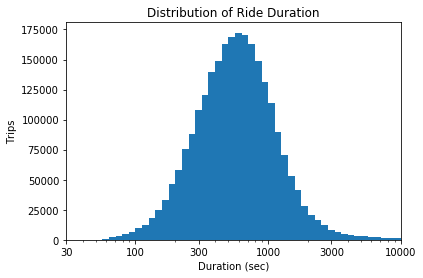

In [9]:
# Creating bin edges based on the data
bin_edges = 10**np.arange(0, np.log10(df.duration_sec.max())+0.05,0.05)
plt.hist(data = df,x = 'duration_sec',bins = bin_edges)
plt.xscale('log')
# Creating tick that are more readable
ticks = [30,100,300,1000,3000,10000,30000,100000]
plt.xticks(ticks,ticks)
plt.xlim(30,10000)
plt.title('Distribution of Ride Duration')
plt.xlabel('Duration (sec)')
plt.ylabel('Trips');

- Trip duration has a log-normal distribution that peaks around 700 seconds.

In [10]:
# Ordering data for plotting
week_order = pd.api.types.CategoricalDtype(ordered = True, categories = day_of_week.values())
df['day_of_week'] = df['day_of_week'].astype(week_order)

month_order = pd.api.types.CategoricalDtype(ordered = True, categories = months.values())
df['month']=df['month'].astype(month_order)

In [11]:
# Formula for creating bar plots based on counts
def countplot(x, color, hue):
    sb.countplot(data = df, x = x, color = color, hue = hue)
    plt.ylabel('Trips')

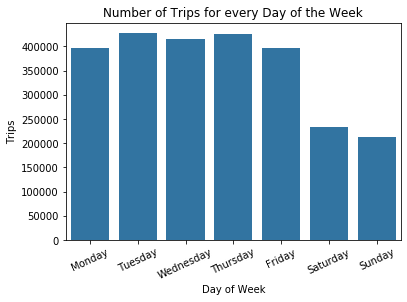

In [12]:
base_color = sb.color_palette()[0]

countplot(x = 'day_of_week', color = base_color,hue = None)
plt.title('Number of Trips for every Day of the Week')
plt.xlabel('Day of Week')
plt.xticks(rotation = 25);

- There were more trips being made on weekdays when compared to weekends. 
- This could be because there were more people commuting during the weekdays. 

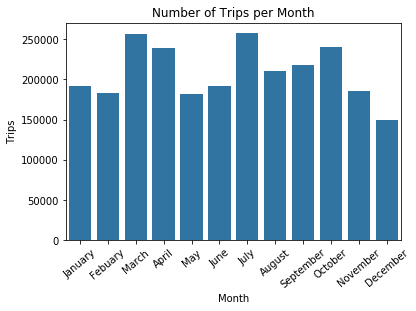

In [13]:
countplot(x = 'month', color = base_color, hue = None)
plt.title('Number of Trips per Month')
plt.xlabel('Month')
plt.xticks(rotation = 40);

- Number of trips varied by month with peaks in the months of March and July. 
- The least amount of trips were made in December.

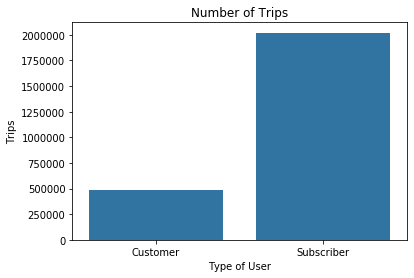

In [14]:
countplot(x = 'user_type', color = base_color, hue = None)
plt.title('Number of Trips')
plt.xlabel("Type of User");

- Members (subscribers) made more trips than casual users (customers) in 2019.

### Observations:
- The distribution of trip duration were heavily skewed to the right. 
- The distribution of trip duration becomes normal after using a log transformation on the x values.
- I also noticed that the number of trips varied by month, type of user, and day of week.

## Bivariate Exploration

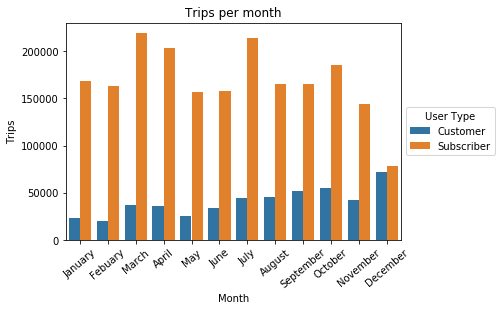

In [15]:
countplot(x = 'month',color = None, hue = 'user_type')
plt.title('Trips per month')
plt.xlabel('Month')
plt.legend(title = 'User Type',loc = 6, bbox_to_anchor = (1,.5))
plt.xticks(rotation = 40);

- Number of trips made by subscribers went down significantly in December. 
- Number of trips made by customers went up. 

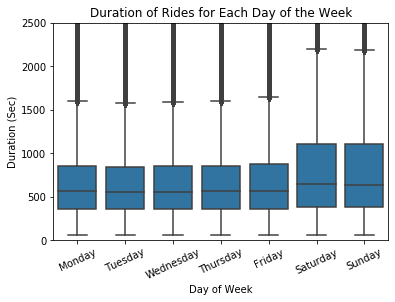

In [16]:
sb.boxplot(data = df, x = 'day_of_week', y = 'duration_sec', color = base_color)
plt.title('Duration of Rides for Each Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Duration (Sec)')
plt.xticks(rotation = 25)
plt.ylim(0,2500);

- Trips taken during the weekend were longer. Shown by the higher median and upper quartiles.

In [17]:
# Formula for creating bar charts
def barplot(x, y, color, hue):
    sb.barplot(data = df, x = x, y = y, color = color, hue = hue)
    plt.ylabel('Duration (Sec)')

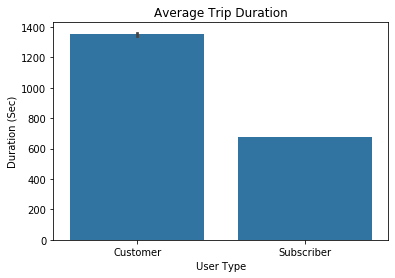

In [18]:
barplot(x = 'user_type', y = 'duration_sec', color = base_color, hue = None)
plt.title('Average Trip Duration')
plt.xlabel('User Type');

- Customers had longer commutes than subscribers.

### Observations:
- Although the number of trips being taken on the weekend were lower, the duration of trips on the weekends were higher.
- Similarly, despite customers making less trips than subscribers, the average trip for a customer took longer.
- As the year progresses, the number of subscribers gradually goes down, but the number of customers increase.

## Multivariate Exploration

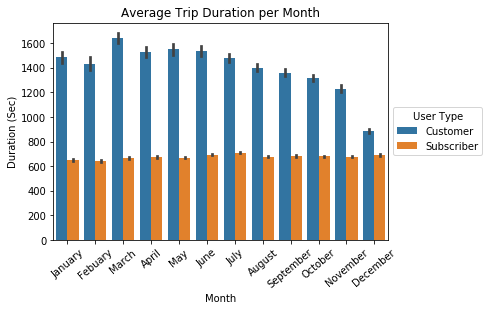

In [19]:
barplot(x = 'month', y = 'duration_sec',color = None, hue = 'user_type')
plt.title('Average Trip Duration per Month')
plt.xlabel('Month')
plt.legend(title = 'User Type',loc = 6, bbox_to_anchor = (1,.5))
plt.xticks(rotation = 40);

- Customers, on average, had longer ride durations subscribers for every month in a year.
- Average trip duration also peaked in March. 
- In December the ride durations between customers and subscribers were the closest. 
- The average duration of trips were almost constant for subscribers.

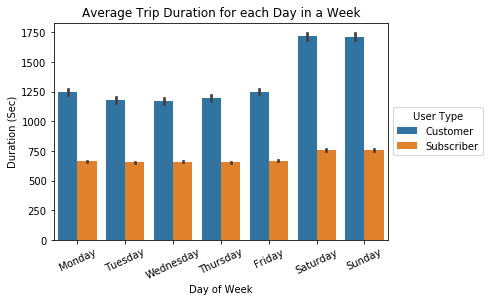

In [20]:
barplot(x = 'day_of_week', y = 'duration_sec',color = None, hue = 'user_type')
plt.title('Average Trip Duration for each Day in a Week')
plt.xlabel('Day of Week')
plt.legend(title = 'User Type',loc = 6, bbox_to_anchor = (1,.5))
plt.xticks(rotation = 25);

- Customers on average have longer trips than subscribers for every day of the week.
- There was a spike in average ride duration during the weekends for both customers and subscribers.

### Observations:
- Looking closer at day of the week and month, strengthened my finding that customers on average take longer trips than subscribers. 
- Customers not only have longer trip durations in general but also at a daily and monthly level.
- The amount of trips being taken seems to have a negative correlation with the average duration of trips.

# Conclusions
1. On average trips in March took the longest, March also had the most trips being made. December had the least and shortest trips.
2. There were more trips being made on weekdays than weekends but trips made on weekends took longer.
3. There were significantly more subscribers than customers in 2019. However customers took longer trips (average 1300 seconds).
4. The Average trip duration made by subscribers was constant in 2019 (700 seconds) 
5. Customers still had longer trips than subscribers when accounting for month and day of week. 